# KLASIFIKASI NAIVE BAYES, RF, BAGGING

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pandas as pd

In [2]:

%pip install pymysql
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv("Data/ecoli.csv")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pymysql
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter

## DATA TIDAK SEIMBANG

Distribusi kelas:
cp: 143 samples (42.6%)
im: 77 samples (22.9%)
imL: 2 samples (0.6%)
imS: 2 samples (0.6%)
imU: 35 samples (10.4%)
om: 20 samples (6.0%)
omL: 5 samples (1.5%)
pp: 52 samples (15.5%)


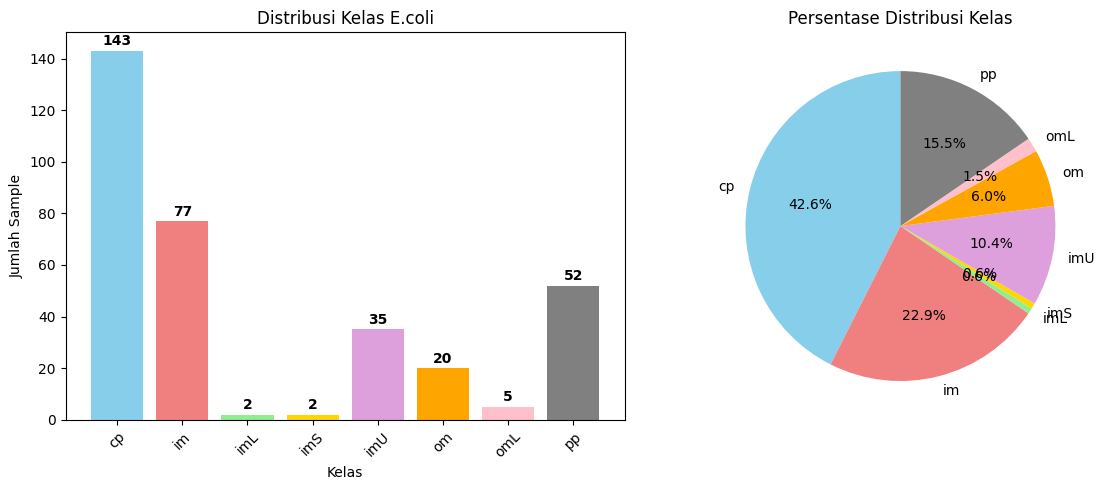


Kelas terbanyak: cp (42.6%)
Kelas tersedikit: imL (0.6%)
Rasio ketidakseimbangan: 71.5:1
Status: TIDAK SEIMBANG


In [5]:
if df is not None:
    class_counts = df['class'].value_counts().sort_index()

    print("Distribusi kelas:")
    for class_name, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{class_name}: {count} samples ({percentage:.1f}%)")

    plt.figure(figsize=(12, 5))

    # 1. Bar Chart
    plt.subplot(1, 2, 1)
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold',
              'plum', 'orange', 'pink', 'gray']
    bars = plt.bar(class_counts.index, class_counts.values,
                   color=colors[:len(class_counts)])
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sample')
    plt.title('Distribusi Kelas E.coli')
    plt.xticks(rotation=45)

    # Tambah label angka di atas bar
    for bar, count in zip(bars, class_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', va='bottom', fontweight='bold')

    # 2. Pie Chart
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors[:len(class_counts)], startangle=90)
    plt.title('Persentase Distribusi Kelas')

    plt.tight_layout()
    plt.show()

    # === 5. Status keseimbangan ===
    max_pct = (class_counts.max() / len(df)) * 100
    min_pct = (class_counts.min() / len(df)) * 100
    ratio = max_pct / min_pct

    print(f"\nKelas terbanyak: {class_counts.idxmax()} ({max_pct:.1f}%)")
    print(f"Kelas tersedikit: {class_counts.idxmin()} ({min_pct:.1f}%)")
    print(f"Rasio ketidakseimbangan: {ratio:.1f}:1")

    if ratio > 3:
        print("Status: TIDAK SEIMBANG")
    else:
        print("Status: RELATIF SEIMBANG")

else:
    print("Data tidak tersedia!")

Data shape: (336, 9)
Columns: ['sequence_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'class']


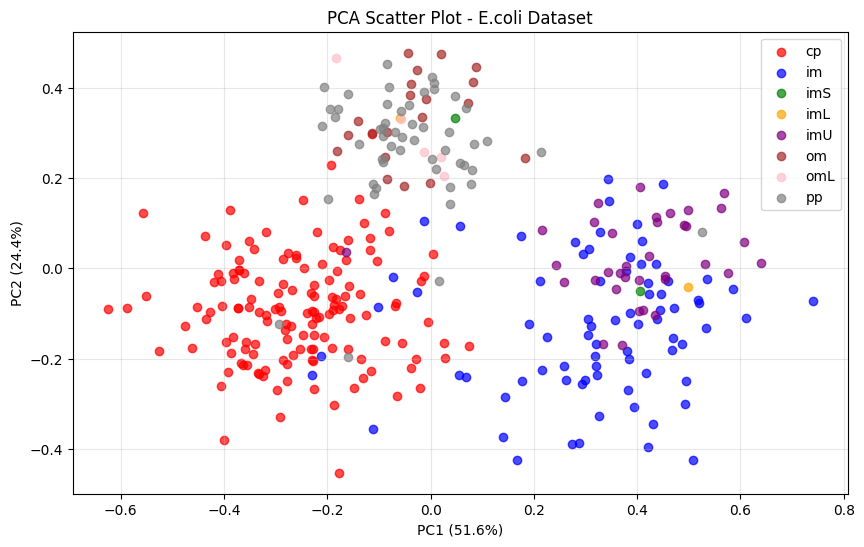

Total variance explained: 76.0%
PCA components shape: (336, 2)

DataFrame PCA (5 baris pertama):
          PC1       PC2 class
0   -0.285601 -0.035274    cp
1   -0.290838 -0.330159    cp
2   -0.104676  0.015248    cp
3   -0.087943  0.122218    cp
4   -0.366268 -0.210366    cp
..        ...       ...   ...
331  0.084233  0.274803    pp
332 -0.139026  0.274116    pp
333 -0.111904  0.187103    pp
334 -0.106204  0.178851    pp
335  0.108764  0.281129    pp

[336 rows x 3 columns]


In [6]:
if df is not None:
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    feature_columns = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
    X = df[feature_columns]
    y = df['class']

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    dataframe_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    dataframe_pca['class'] = y.values

    # Plot scatter
    plt.figure(figsize=(10, 6))

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    for i, class_name in enumerate(y.unique()):
        mask = y == class_name
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=colors[i], label=class_name, alpha=0.7)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title('PCA Scatter Plot - E.coli Dataset')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.1%}")
    print("PCA components shape:", X_pca.shape)
    print("\nDataFrame PCA (5 baris pertama):")
    print(dataframe_pca)

### KLASIFIKASI DATA TIDAK SEIMBANG

NAIVE BAYES (DATA TIDAK SEIMBANG)

In [7]:
# Pastikan Anda telah mengimpor semua yang dibutuhkan:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Drop kolom non-numerik (selain target)
X = df.drop(columns=['class'])
# Deteksi kolom numerik saja
X = X.select_dtypes(include=['float64', 'int64'])

y = df['class']

# Split data (stratify supaya distribusi kelas tetap proporsional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Prediksi
y_pred = nb.predict(X_test)

# Evaluasi
print("🔹 Akurasi Naive Bayes (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Baris ini (acc, report, cm) akan error lagi jika Anda tidak mendefinisikannya.
# Kemungkinan Anda bermaksud menampilkan nilai yang sudah di-print di atas.
# Jika Anda ingin menyimpan hasilnya:
# acc = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)

🔹 Akurasi Naive Bayes (data asli): 0.7920792079207921

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.96        43
          im       0.75      0.65      0.70        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.62      0.50      0.56        10
          om       0.00      0.00      0.00         6
         omL       0.50      1.00      0.67         1
          pp       0.67      1.00      0.80        16

    accuracy                           0.79       101
   macro avg       0.43      0.52      0.46       101
weighted avg       0.73      0.79      0.75       101


Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 4 15  0  0  3  0  0  1]
 [ 0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  4  0  0  5  0  0  1]
 [ 0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 16]]


/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

RANDOM FOREST (DATA TIDAK SEIMBANG)

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Drop kolom non-numerik (selain target)
X = df.drop(columns=['class'])
# Deteksi kolom numerik saja
X = X.select_dtypes(include=['float64', 'int64'])

y = df['class']

# Split data (stratify supaya distribusi kelas tetap proporsional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

# Evaluasi
print("🔹 Akurasi Random Forest (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (data asli): 0.8217821782178217

Classification Report:
               precision    recall  f1-score   support

          cp       0.93      1.00      0.97        43
          im       0.73      0.70      0.71        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.46      0.60      0.52        10
          om       1.00      0.83      0.91         6
         omL       0.50      1.00      0.67         1
          pp       0.92      0.75      0.83        16

    accuracy                           0.82       101
   macro avg       0.57      0.61      0.58       101
weighted avg       0.82      0.82      0.82       101


Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 1 16  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  4  0  0  6  0  0  0]
 [ 0  0  0  0  0  5  0  1]
 [ 0  0  0  0  0  0  1  0]
 [ 2  1  0  0  1  0  0 12]]


/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

BAGGING CLASSIFIER (DATA TIDAK SEIMBANG)
BaggingClassifier menggunakan decision tree classifier sebagai base estimator


In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# === Bagging Classifier ===
base_clf = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    random_state=42,
    bootstrap=True
)

bagging.fit(X_train, y_train)

# Prediksi
y_pred = bagging.predict(X_test)

# Evaluasi
print("🔹 Akurasi Bagging Classifier (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging Classifier (data asli): 0.8217821782178217

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.96        43
          im       0.70      0.70      0.70        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.46      0.60      0.52        10
          om       1.00      1.00      1.00         6
         omL       1.00      1.00      1.00         1
          pp       1.00      0.69      0.81        16

    accuracy                           0.82       101
   macro avg       0.63      0.62      0.62       101
weighted avg       0.82      0.82      0.82       101


Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 1 16  0  0  6  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  4  0  0  6  0  0  0]
 [ 0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 2  2  0  0  1  0  0 11]]


/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/PSD/ecoli-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

## DATA DISEIMBANGKAN MENGGUNAKAN ADASYN

In [10]:

print("Distribusi kelas sebelum ADASYN:")
print(f"{sorted(Counter(y).items())}")

nt = X
ns = y

temp = sorted(class_counts)
print(f"Sorted counts untuk iterasi: {temp}")

for i in range(0, 7):
    n = max(1, temp[i] - 1)

    print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        nt, ns = ADASYN(n_neighbors=n, sampling_strategy='minority').fit_resample(nt, ns)
        print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")

Distribusi kelas sebelum ADASYN:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]
Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Iterasi 1: menggunakan k_neighbors=1
Hasil iterasi 1: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 2: menggunakan k_neighbors=1
Hasil iterasi 2: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 3: menggunakan k_neighbors=4
Hasil iterasi 3: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 143), ('pp', 52)]

Iterasi 4: menggunakan k_neighbors=19
Hasil iterasi 4: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 5: menggunakan k_neighbors=34
Hasil iterasi 5: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 143), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 

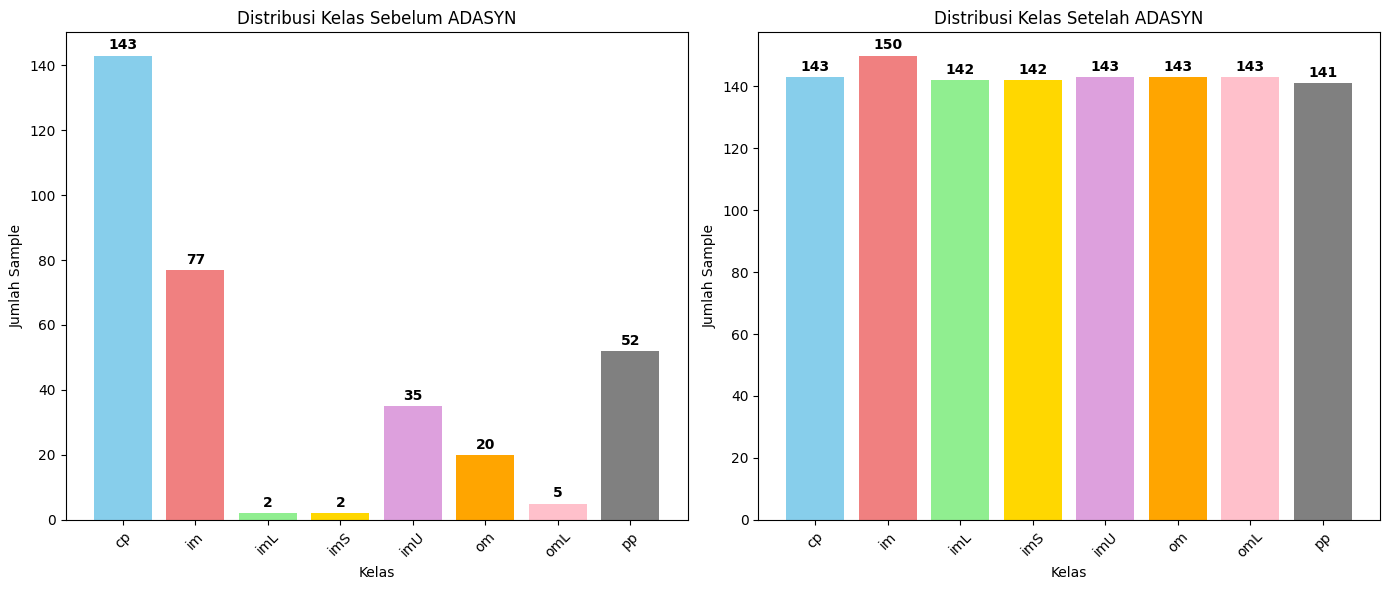


=== SUMMARY ADASYN ===
Peningkatan per kelas:
  cp: 0 samples (143 → 143)
  im: +73 samples (77 → 150)
  imL: +140 samples (2 → 142)
  imS: +140 samples (2 → 142)
  imU: +108 samples (35 → 143)
  om: +123 samples (20 → 143)
  omL: +138 samples (5 → 143)
  pp: +89 samples (52 → 141)


In [11]:
# Visualisasi perbandingan sebelum dan sesudah ADASYN
plt.figure(figsize=(14, 6))


original_counts = Counter(y)
adasyn_counts = Counter(ns)
classes = sorted(original_counts.keys())

original_values = [original_counts[cls] for cls in classes]
adasyn_values = [adasyn_counts[cls] for cls in classes]

# Plot 1: Sebelum ADASYN
plt.subplot(1, 2, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'pink', 'gray']
bars1 = plt.bar(classes, original_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Sebelum ADASYN')
plt.xticks(rotation=45)

for bar, count in zip(bars1, original_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Setelah ADASYN
plt.subplot(1, 2, 2)
bars2 = plt.bar(classes, adasyn_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Setelah ADASYN')
plt.xticks(rotation=45)

for bar, count in zip(bars2, adasyn_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\n=== SUMMARY ADASYN ===")
print(f"Peningkatan per kelas:")
for cls in classes:
    increase = adasyn_counts[cls] - original_counts[cls]
    if increase > 0:
        print(f"  {cls}: +{increase} samples ({original_counts[cls]} → {adasyn_counts[cls]})")
    else:
        print(f"  {cls}: {increase} samples ({original_counts[cls]} → {adasyn_counts[cls]})")

### KLASIFIKASI DATA SEIMBANG (ADASYN)

NAIVE BAYES (ADASYN)

In [12]:
# Split data ADASYN
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.3, random_state=42, stratify=ns
)

# Inisialisasi Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi
y_pred = nb.predict(X_test)

# Evaluasi
print("🔹 Akurasi Naive Bayes (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (ADASYN): 0.8724637681159421

Classification Report:
               precision    recall  f1-score   support

          cp       0.77      1.00      0.87        43
          im       0.96      0.56      0.70        45
         imL       1.00      1.00      1.00        43
         imS       0.91      1.00      0.96        43
         imU       0.83      0.81      0.82        43
          om       1.00      0.70      0.82        43
         omL       1.00      1.00      1.00        43
          pp       0.67      0.93      0.78        42

    accuracy                           0.87       345
   macro avg       0.89      0.87      0.87       345
weighted avg       0.89      0.87      0.87       345


Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 6 25  0  3  7  0  0  4]
 [ 0  0 43  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0]
 [ 3  1  0  1 35  0  0  3]
 [ 1  0  0  0  0 30  0 12]
 [ 0  0  0  0  0  0 43  0]
 [ 3  0  0  0  0  0  0 39]]


RANDOM FOREST (ADASYN)

In [13]:
# Split data ADASYN (sudah sama seperti sebelumnya, jadi bisa pakai ulang)
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

# Evaluasi
print("🔹 Akurasi Random Forest (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (ADASYN): 0.9608695652173913

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.95        29
          im       0.93      0.83      0.88        30
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        28
         imU       0.87      0.93      0.90        29
          om       1.00      1.00      1.00        29
         omL       1.00      1.00      1.00        29
          pp       1.00      0.93      0.96        28

    accuracy                           0.96       230
   macro avg       0.96      0.96      0.96       230
weighted avg       0.96      0.96      0.96       230


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 1 25  0  0  4  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  2  0  0 27  0  0  0]
 [ 0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 26]]


BAGGING CLASSIFIER (ADASYN)
BaggingClassifier menggunakan decision tree classifier sebagai base estimator

In [14]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("🔹 Akurasi Bagging (Decision Tree, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Decision Tree, ADASYN): 0.9521739130434783

Classification Report:
               precision    recall  f1-score   support

          cp       0.90      0.97      0.93        29
          im       0.89      0.83      0.86        30
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        28
         imU       0.87      0.90      0.88        29
          om       1.00      1.00      1.00        29
         omL       1.00      1.00      1.00        29
          pp       0.96      0.93      0.95        28

    accuracy                           0.95       230
   macro avg       0.95      0.95      0.95       230
weighted avg       0.95      0.95      0.95       230


Confusion Matrix:
 [[28  0  0  0  0  0  0  1]
 [ 1 25  0  0  4  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  3  0  0 26  0  0  0]
 [ 0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 26]]


## DATA DISEIMBANGKAN (SMOTE)

In [15]:
print("Distribusi kelas sebelum SMOTE:")
print(f"{sorted(Counter(y).items())}")

smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print(f"\nDistribusi kelas setelah SMOTE:")
print(f"{sorted(Counter(y_res).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(y_res)}")
print(f"Data yang ditambahkan: {len(y_res) - len(y)}")

Distribusi kelas sebelum SMOTE:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Distribusi kelas setelah SMOTE:
[('cp', 143), ('im', 143), ('imL', 143), ('imS', 143), ('imU', 143), ('om', 143), ('omL', 143), ('pp', 143)]

Total samples sebelum: 336
Total samples setelah: 1144
Data yang ditambahkan: 808


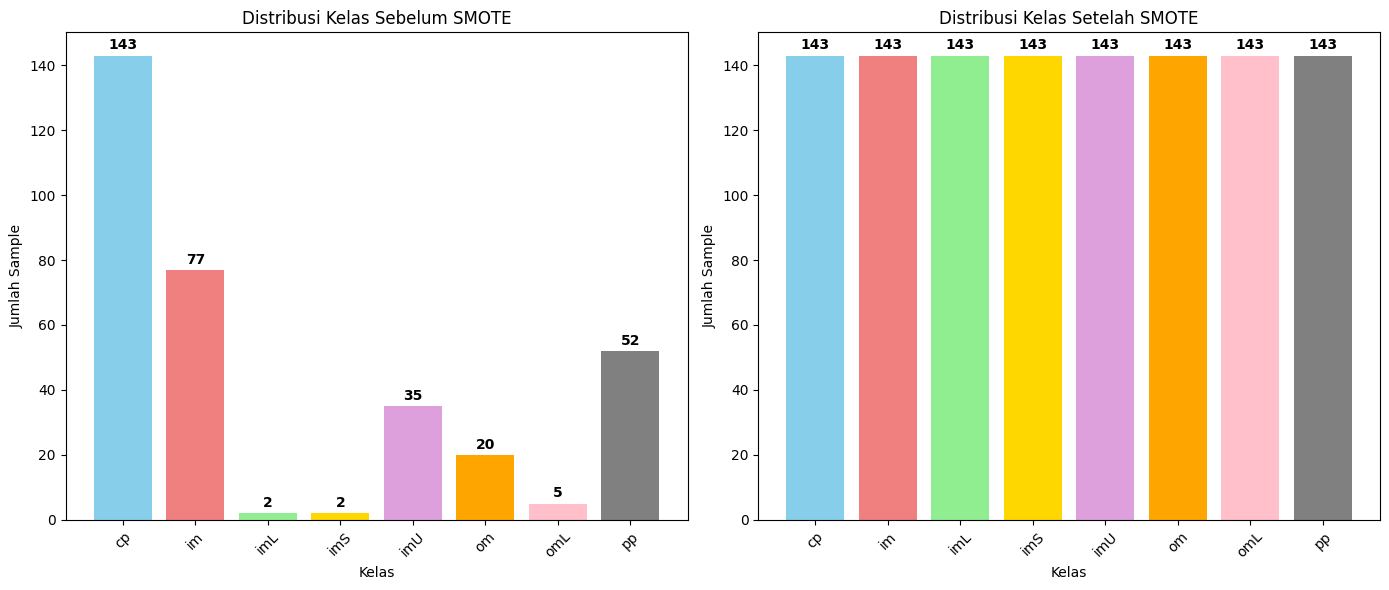


=== SUMMARY SMOTE ===
Peningkatan per kelas:
  cp: 0 samples (143 → 143)
  im: +66 samples (77 → 143)
  imL: +141 samples (2 → 143)
  imS: +141 samples (2 → 143)
  imU: +108 samples (35 → 143)
  om: +123 samples (20 → 143)
  omL: +138 samples (5 → 143)
  pp: +91 samples (52 → 143)


In [16]:
plt.figure(figsize=(14, 6))

original_counts_smote = Counter(y)
smote_counts = Counter(y_res)
classes = sorted(original_counts_smote.keys())

original_values = [original_counts_smote[cls] for cls in classes]
smote_values = [smote_counts[cls] for cls in classes]

# Plot 1: Sebelum SMOTE
plt.subplot(1, 2, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'pink', 'gray']
bars1 = plt.bar(classes, original_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xticks(rotation=45)

for bar, count in zip(bars1, original_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Setelah SMOTE
plt.subplot(1, 2, 2)
bars2 = plt.bar(classes, smote_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xticks(rotation=45)

for bar, count in zip(bars2, smote_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\n=== SUMMARY SMOTE ===")
print(f"Peningkatan per kelas:")
for cls in classes:
    increase = smote_counts[cls] - original_counts_smote[cls]
    if increase > 0:
        print(f"  {cls}: +{increase} samples ({original_counts_smote[cls]} → {smote_counts[cls]})")
    else:
        print(f"  {cls}: {increase} samples ({original_counts_smote[cls]} → {smote_counts[cls]})")

### KLASIFIKASI DATA SEIMBANG (SMOTE)

NAIVE BAYES (SMOTE)

In [20]:
# === Import library ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# === Asumsikan dataset sudah ada dalam X, y ===
# contoh: X = df.drop("label", axis=1)
#         y = df["label"]

# Cek distribusi awal
print("Distribusi kelas sebelum SMOTE:")
print(pd.Series(y).value_counts())

# === Resampling dengan SMOTE ===
# Gunakan k_neighbors=1 agar tidak error jika ada kelas dengan data sedikit
sm = SMOTE(random_state=42, k_neighbors=1)
x_sm, y_sm = sm.fit_resample(X, y)

print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_sm).value_counts())

# === Split data ===
x_train, x_test, y_train, y_test = train_test_split(
    x_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# ===============================
# 1. Naive Bayes
# ===============================
nb = GaussianNB(var_smoothing=1e-8)
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

print("\n=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

# ===============================
# 2. Random Forest
# ===============================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Distribusi kelas sebelum SMOTE:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imL      2
imS      2
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
class
cp     143
im     143
imS    143
imL    143
imU    143
om     143
omL    143
pp     143
Name: count, dtype: int64

=== Naive Bayes ===
Accuracy: 0.8646288209606987
Classification Report:
               precision    recall  f1-score   support

          cp       0.80      1.00      0.89        28
          im       1.00      0.50      0.67        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.81      0.86      0.83        29
          om       1.00      0.61      0.76        28
         omL       1.00      1.00      1.00        29
          pp       0.60      0.93      0.73        29

    accuracy                           0.86       229
   macro avg       0.90      0.86      0.86       229
weighted avg       0.90  

RANDOM FOREST (SMOTE)

In [22]:
sm = SMOTE(random_state=42, k_neighbors=1)   # k_neighbors=1 supaya tidak error
X_sm, y_sm = sm.fit_resample(X, y)

print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_sm).value_counts())

# === Split data hasil SMOTE ===
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# === Random Forest ===
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Random Forest (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Distribusi kelas setelah SMOTE:
class
cp     143
im     143
imS    143
imL    143
imU    143
om     143
omL    143
pp     143
Name: count, dtype: int64
🔹 Akurasi Random Forest (SMOTE): 0.9519650655021834

Classification Report:
               precision    recall  f1-score   support

          cp       0.88      1.00      0.93        28
          im       0.89      0.86      0.87        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.89      0.86      0.88        29
          om       1.00      0.96      0.98        28
         omL       1.00      1.00      1.00        29
          pp       0.96      0.93      0.95        29

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 24  0  0  3  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  

BAGGING CLASSIFIER (SMOTE)
BaggingClassifier menggunakan decision tree classifier sebagai base estimator

In [23]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("🔹 Akurasi Bagging (Decision Tree, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Decision Tree, SMOTE): 0.9432314410480349

Classification Report:
               precision    recall  f1-score   support

          cp       0.85      1.00      0.92        28
          im       0.92      0.82      0.87        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.86      0.86      0.86        29
          om       0.96      0.96      0.96        28
         omL       1.00      1.00      1.00        29
          pp       0.96      0.90      0.93        29

    accuracy                           0.94       229
   macro avg       0.94      0.94      0.94       229
weighted avg       0.95      0.94      0.94       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 23  0  0  4  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 2  2  0  0 25  0  0  0]
 [ 0  0  0  0  0 27  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  1  0 26]]
